### Simple rule-based allocation of weights for a portfolio of stocks

#### Import libraries

In [1]:
import pandas as pd
import numpy as np 
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import permutations, combinations
%matplotlib inline

#### Various function definitions

In [107]:
def get_price_df(sym_type):
    syms_1 = ['^NSEI', 'NATIONALUM.NS', 'BHEL.NS', 'YESBANK.NS', 'GAIL.NS', 'MRPL.NS', 'ONGC.NS', 'SJVN.NS', 'TATAPOWER.NS']
    syms_2 = ['^BSESN', '^DJI', '^FCHI', '^FTSE', '^GDAXI', '^GSPC', '^IXIC', '^NSEI']
    syms_3 = ['BAJAJ-AUTO.NS', 'ULTRACEMCO.NS', 'NTPC.NS', 'CIPLA.NS', 'HEROMOTOCO.NS', 'ITC.NS', 'SHREECEM.NS', 'HDFCLIFE.NS','WIPRO.NS','COALINDIA.NS'] 
    syms_4 = ['SHREECEM.NS', 'NESTLEIND.NS', 'MARUTI.NS', 'BAJAJFINSV.NS', 'ULTRACEMCO.NS', 'HEROMOTOCO.NS', 'BAJAJ-AUTO.NS', 'BRITANNIA.NS', 'BAJFINANCE.NS','TCS.NS']
    
    if sym_type == 'equities':
        price_df = pd.read_csv('datasets/nse_equities_20160101_20201130.csv')
        syms = syms_1
    elif sym_type == 'index':
        price_df = pd.read_csv('datasets/index_ohlcv_10yrs.csv')
        price_df = price_df.rename(columns={'index-name':'sym'})
        syms = syms_2
    elif sym_type == 'nifty_top_10_sharpe':
        price_df = pd.read_csv('datasets/nse_top_30_equities_20160101_20201130.csv')
        price_df = price_df.rename(columns={'equity-name':'sym'})
        price_df = price_df[price_df['sym'].isin(syms_3)]
        syms = syms_3
    elif sym_type == 'nifty_top_10_mean':
        price_df = pd.read_csv('datasets/nse_top_30_equities_20160101_20201130.csv')
        price_df = price_df.rename(columns={'equity-name':'sym'})
        price_df = price_df[price_df['sym'].isin(syms_4)]
        syms = syms_4
    else:
        print("Invalid type")

    price_df = price_df.reset_index(drop=True)
    
    return price_df, syms

In [3]:
def get_ret_df(price_df):
    ret_df = price_df[['Date', 'sym', 'Adj Close']].copy()
    ret_df = ret_df.pivot(index='Date', columns='sym', values='Adj Close')
    ret_df = ret_df/ret_df.shift(1) - 1
    
    return ret_df.dropna(axis=0, how='any')

In [4]:
def get_filt_df(df_type, price_df):
    if df_type == 1: 
        '''
        Arithmetic returns
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df = filt_df/filt_df.shift(1) - 1

    elif df_type == 2:
        '''
        Volume change 
        '''
        filt_df = price_df[['Date', 'sym', 'Volume']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Volume').dropna(axis=0, how='any')
        filt_df = filt_df/filt_df.shift(1) - 1 
        
    elif df_type == 3:
        '''
        MA5
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma5 = filt_df.rolling(window=5).mean()
        filt_df = filt_df_ma5/filt_df_ma5.shift(1) - 1
    
    elif df_type == 4:
        '''
        MA20 
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma20 = filt_df.rolling(window=20).mean()
        filt_df = filt_df_ma20/filt_df_ma20.shift(1) - 1
        
    elif df_type == 5:
        '''
        MA50
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma50 = filt_df.rolling(window=50).mean()
        filt_df = filt_df_ma50/filt_df_ma50.shift(1) - 1
        
    elif df_type == 6: 
        '''
        MA120
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma120 = filt_df.rolling(window=120).mean()
        filt_df = filt_df_ma120/filt_df_ma120.shift(1) - 1
        
    elif df_type == 7:
        '''
        AVG(MA20, MA50)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma20 = filt_df.rolling(window=20).mean().dropna(axis=0, how='any')
        filt_df_ma50 = filt_df.rolling(window=50).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma20 + filt_df_ma50)/2
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 8:
        '''
        AVG(MA50, MA120)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma_50 = filt_df.rolling(window=50).mean().dropna(axis=0, how='any')
        filt_df_ma_120 = filt_df.rolling(window=120).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma_50 + filt_df_ma_120)/2
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 9:
        '''
        AVG(MA20, MA120)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma_20 = filt_df.rolling(window=20).mean().dropna(axis=0, how='any')
        filt_df_ma_120 = filt_df.rolling(window=120).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma_20 + filt_df_ma_120)/2
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 10: 
        '''
        AVG(MA20, MA50, MA120)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma_20 = filt_df.rolling(window=20).mean().dropna(axis=0, how='any')
        filt_df_ma_50 = filt_df.rolling(window=50).mean().dropna(axis=0, how='any')
        filt_df_ma_120 = filt_df.rolling(window=120).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma_20 + filt_df_ma_50 + filt_df_ma_120)/3 
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 11:
        '''
        EWMA5
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma5 = filt_df.ewm(span=5, min_periods=5).mean()
        filt_df = filt_df_ma5/filt_df_ma5.shift(1) - 1
        
    elif df_type == 12:
        '''
        EWMA20
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma20 = filt_df.ewm(span=20, min_periods=20).mean()
        filt_df = filt_df_ma20/filt_df_ma20.shift(1) - 1
        
    elif df_type == 13:
        '''
        EWMA50
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma50 = filt_df.ewm(span=50, min_periods=50).mean()
        filt_df = filt_df_ma50/filt_df_ma50.shift(1) - 1
        
    elif df_type == 14:
        '''
        EWMA120
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma120 = filt_df.ewm(span=120, min_periods=120).mean()
        filt_df = filt_df_ma120/filt_df_ma120.shift(1) - 1
        
    elif df_type == 15:
        '''
        AVG(EWMA20, EWMA50)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma20 = filt_df.ewm(span=20, min_periods=20).mean().dropna(axis=0, how='any')
        filt_df_ma50 = filt_df.ewm(span=50, min_periods=50).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma20 + filt_df_ma50)/2
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 16:
        '''
        AVG(EWMA50, EWMA120)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma_50 = filt_df.ewm(span=50, min_periods=50).mean().dropna(axis=0, how='any')
        filt_df_ma_120 = filt_df.ewm(span=120, min_periods=120).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma_50 + filt_df_ma_120)/2
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 17: 
        '''
        AVG(EWMA20, EWMA120)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma_20 = filt_df.ewm(span=20, min_periods=20).mean().dropna(axis=0, how='any')
        filt_df_ma_120 = filt_df.ewm(span=120, min_periods=120).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma_20 + filt_df_ma_120)/2
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 18:
        '''
        AVG(EWMA20, EWMA50, EWMA120)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma_20 = filt_df.ewm(span=20, min_periods=20).mean().dropna(axis=0, how='any')
        filt_df_ma_50 = filt_df.ewm(span=50, min_periods=50).mean().dropna(axis=0, how='any')
        filt_df_ma_120 = filt_df.ewm(span=120, min_periods=120).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma_20 + filt_df_ma_50 + filt_df_ma_120)/3 
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    filt_df.dropna(axis=0, how='any', inplace=True)
    filt_df = filt_df.div(filt_df.sum(axis=1), axis=0)
    
    return filt_df

In [144]:
def return_pval_df(syms, value, rdf, idf): 
    ret_cols  = list(rdf.columns)[1:]
    pval_cols = [ 'pval_' + val.replace('ret_','') for val in ret_cols ]
    rdf['return'] = 0
    
    for i in range(len(syms)-1):
        rdf.loc[:, pval_cols[i]] = rdf.loc[:, ret_cols[i]] * idf.loc[:, ret_cols[i]].shift(1) * value 
        rdf['return'] = rdf['return'] + rdf[pval_cols[i]]
    
    rdf = rdf.replace([-np.inf, np.inf], np.nan).dropna(axis=0, how='any').reset_index(drop=True)
    
    pvalue_mean   = round(rdf['return'].mean(), 4)
    pvalue_std    = round(rdf['return'].std(), 4)
    pvalue_sharpe = round(pvalue_mean / pvalue_std * pow(252, 0.5), 4)
    
    return pvalue_mean, pvalue_std, pvalue_sharpe, rdf

In [6]:
def plot_pval(pval_df): 
    pval_df['return'].plot(grid=True, title='return', kind='line', rot='45')  
    plt.show()

In [79]:
def get_portfolio_data(syms, value, filt_df, ret_df, ret=None):
    ind_df, ret_value_df = filt_df[syms].copy(), ret_df[syms].copy()
    pvalue_mean, pvalue_std, pvalue_sharpe, pval_df  = return_pval_df(syms, value, ret_value_df, ind_df)
    
    if ret == None:
        print("Mean    : {}".format(pvalue_mean))
        print("Std     : {}".format(pvalue_std))
        print("Sharpe  : {}".format(pvalue_sharpe))
        plot_pval(pval_df)
    else:
        return pvalue_mean, pvalue_std, pvalue_sharpe

In [74]:
def get_portfolio_stats(value, df_type, sym_type, ret=None):
    price_df, syms = get_price_df(sym_type)
    ret_df  = get_ret_df(price_df)
    filt_df = get_filt_df(df_type, price_df)
    ret_df  = ret_df[ret_df.index.isin(filt_df.index.tolist())]
    if ret == None:
        get_portfolio_data(syms, value, filt_df, ret_df)
    else:
        mean, std, sharpe = get_portfolio_data(syms, value, filt_df, ret_df, ret)
        return mean, std, sharpe

#### Aggregated Stats

In [154]:
def aggregate_stats(instr, ret=None):
    d_types  = np.arange(1,19)
    #instr    = ['equities', 'index', 'nifty_top_10_sharpe']
    stats_df = pd.DataFrame(columns=['instr', 'd_type', 'mean', 'std', 'sharpe'])
    idx      = 0 
    
    for dt in d_types:
        mean, std, sharpe = get_portfolio_stats(1, dt, instr, "return")
        stats_df.loc[idx] = [instr, dt, mean, std, sharpe]
        idx += 1
     
    if ret is None:
        fig, axes = plt.subplots(1,3, figsize=(15,5))
        stats_df.plot(x='d_type', y='mean', ax=axes[0], grid=True, title=instr + '-mean')
        stats_df.plot(x='d_type', y='std', ax=axes[1], grid=True, title=instr + '-std')
        stats_df.plot(x='d_type', y='sharpe', ax=axes[2], grid=True, title=instr + '-sharpe')
        plt.show()
        
    else: 
        return stats_df
    

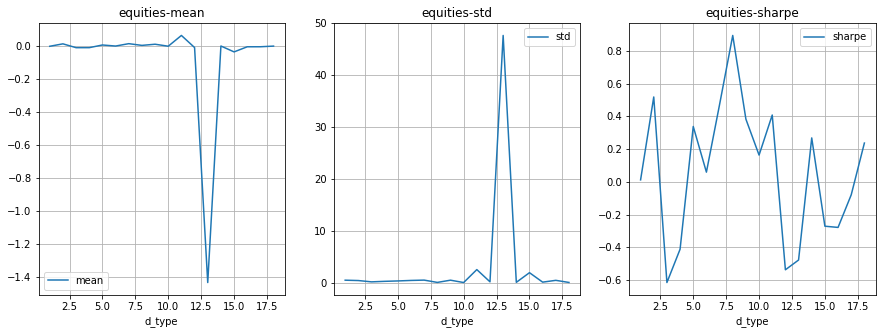

In [146]:
aggregate_stats('equities')

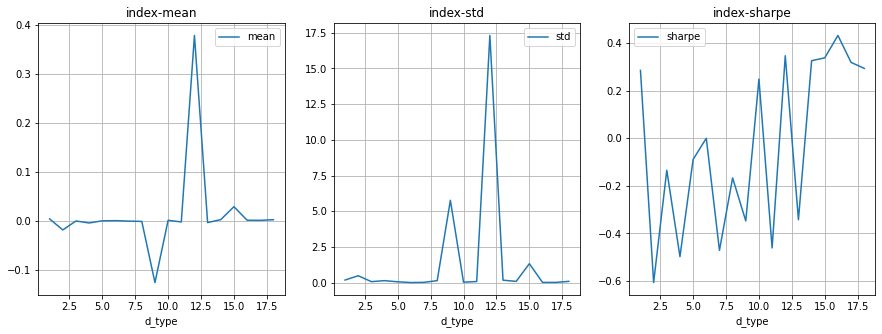

In [147]:
aggregate_stats('index')

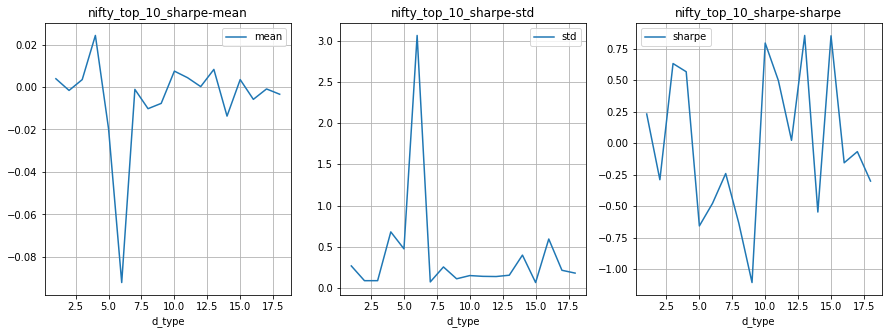

In [148]:
aggregate_stats('nifty_top_10_sharpe')

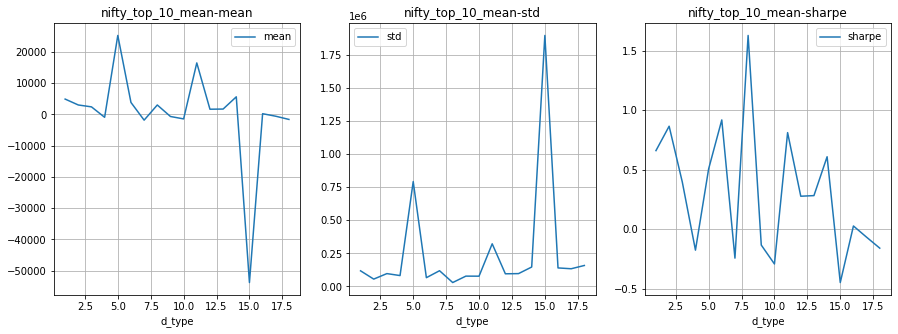

In [155]:
aggregate_stats('nifty_top_10_mean')